In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
os.chdir('/content/gdrive/MyDrive/ViralMut/')

Mounted at /content/gdrive


In [2]:
import warnings

warnings.filterwarnings('ignore')

!mkdir -p ~/.fonts
!cp arial.ttf ~/.fonts/
!fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
from matplotlib import font_manager as fm

font_dir = os.path.join(os.environ['HOME'], '.fonts')
os.makedirs(font_dir, exist_ok=True)
font_name = 'arial.ttf'
font_path = os.path.join(font_dir, font_name)
fm.fontManager.addfont(font_path)

!cp {font_name} {font_dir}

## 1. Load data

In [4]:
import pandas as pd

categories = ['pathogenic', 'benign', 'likely_pathogenic', 'likely_benign']

results = {}

for cat in categories:

    prot = pd.read_csv(f'./LLR/{cat}_LLR_results.csv').add_suffix('_prot')
    gene = pd.read_csv(f'./LLR/{cat}_LLR_CaLM_results.csv').add_suffix('_gene')

    merged = pd.concat([prot.reset_index(drop=True),
                        gene.reset_index(drop=True)], axis=1)

    meta_data = pd.read_csv(f'./data/{cat}_data.csv')

    merged['Chromosome'] = meta_data['Chromosome']

    results[cat] = merged


merged_pathogenic = results['pathogenic']
merged_benign = results['benign']
merged_likely_pathogenic = results['likely_pathogenic']
merged_likely_benign = results['likely_benign']

In [5]:
filtered_pathogenic = merged_pathogenic.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_benign = merged_benign.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_likely_pathogenic = merged_likely_pathogenic.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_likely_benign = merged_likely_benign.dropna(subset=['LLR_prot', 'LLR_gene'])

LLR_path_prot = filtered_pathogenic['LLR_prot'].tolist()
LLR_path_gene = filtered_pathogenic['LLR_gene'].tolist()

LLR_benign_prot = filtered_benign['LLR_prot'].tolist()
LLR_benign_gene = filtered_benign['LLR_gene'].tolist()

LLR_likely_path_prot = filtered_likely_pathogenic['LLR_prot'].tolist()
LLR_likely_path_gene = filtered_likely_pathogenic['LLR_gene'].tolist()

LLR_likely_benign_prot = filtered_likely_benign['LLR_prot'].tolist()
LLR_likely_benign_gene = filtered_likely_benign['LLR_gene'].tolist()

In [6]:
import numpy as np
# Benign + Likely benign = Benign
gene_neg_ids = np.concatenate([
    filtered_benign["Gene_prot"].to_numpy(),
    filtered_likely_benign["Gene_prot"].to_numpy()
])

# Pathogenic + Likely pathogenic = Pathogenic
gene_pos_ids = np.concatenate([
    filtered_pathogenic["Gene_prot"].to_numpy(),
    filtered_likely_pathogenic["Gene_prot"].to_numpy()
])

groups_gene = np.concatenate([gene_neg_ids, gene_pos_ids])

## 2. Bayesian optimization

In [7]:
!pip install bayesian-optimization

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold
from bayes_opt import BayesianOptimization
import seaborn as sns
from matplotlib import ticker
from scipy.stats import gaussian_kde
from typing import List


def run_cv(X_gene, X_prot, y, groups, raw_labels, n_splits=10):

    X_gene = np.array(X_gene)
    X_prot = np.array(X_prot)
    y = np.array(y)
    groups = np.array(groups)
    raw_labels = np.array(raw_labels)

    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=18)

    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)

    results = {
        'Hybrid': {'tprs': [], 'rocs': [], 'weights': [], 'precisions': [], 'prs': []},
        'CaLM':   {'tprs': [], 'rocs': [],                'precisions': [], 'prs': []},
        'ESM-2':  {'tprs': [], 'rocs': [],                'precisions': [], 'prs': []},
        'BO_History': []
    }

    fig2c_storage = {
        'Hybrid_scores': [],
        'CaLM_scores': [],
        'ESM-2_scores': [],
        'True_labels': []
    }

    print(f"Starting {n_splits}-fold CV...")

    for fold_i, (train_idx, test_idx) in enumerate(cv.split(X_gene, y, groups=groups)):


        X_gene_train, X_gene_test = X_gene[train_idx], X_gene[test_idx]
        X_prot_train, X_prot_test = X_prot[train_idx], X_prot[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        labels_test = raw_labels[test_idx]


        def get_roc_for_w(w, Xg, Xp, y_t):
            s = w * Xg + (1 - w) * Xp
            return roc_auc_score(y_t, -s)

        def bo_target(w):
            return get_roc_for_w(w, X_gene_train, X_prot_train, y_train)

        optimizer = BayesianOptimization(f=bo_target, pbounds={'w': (0, 1)}, random_state=48, verbose=0)
        optimizer.maximize(init_points=10, n_iter=20)

        best_w = optimizer.max['params']['w']
        results['Hybrid']['weights'].append(best_w)


        w_grid = np.linspace(0, 1, 100)
        roc_landscape = [get_roc_for_w(w, X_gene_train, X_prot_train, y_train) for w in w_grid]


        bo_sampled_w = [res['params']['w'] for res in optimizer.res]
        bo_sampled_roc = [res['target'] for res in optimizer.res]

        results['BO_History'].append({
            'fold': fold_i,
            'w_grid': w_grid,
            'roc_landscape': roc_landscape,
            'sampled_w': bo_sampled_w,
            'sampled_roc': bo_sampled_roc,
            'best_w': best_w,
            'best_roc': optimizer.max['target']
        })

        #################### Testing #######################
        s_test_hybrid_raw = best_w * X_gene_test + (1 - best_w) * X_prot_test
        s_test_calm_raw = X_gene_test
        s_test_esm_raw = X_prot_test


        fig2c_storage['Hybrid_scores'].extend(s_test_hybrid_raw)
        fig2c_storage['CaLM_scores'].extend(s_test_calm_raw)
        fig2c_storage['ESM-2_scores'].extend(s_test_esm_raw)
        fig2c_storage['True_labels'].extend(labels_test)

        ################### ROC/PR ##########################
        def cal_metrics(name, scores):

            fpr, tpr, _ = roc_curve(y_test, scores)
            roc_auc = auc(fpr, tpr)

            results[name]['tprs'].append(np.interp(mean_fpr, fpr, tpr))
            results[name]['tprs'][-1][0] = 0.0
            results[name]['rocs'].append(roc_auc)

            precision, recall, _ = precision_recall_curve(y_test, scores)
            ap = average_precision_score(y_test, scores)
            interp_prec = np.interp(mean_recall, recall[::-1], precision[::-1])

            results[name]['precisions'].append(interp_prec)
            results[name]['prs'].append(ap)


        cal_metrics('Hybrid', -s_test_hybrid_raw)
        cal_metrics('CaLM', -s_test_calm_raw)
        cal_metrics('ESM-2', -s_test_esm_raw)

        print(f"Fold {fold_i+1}: Best w={best_w:.2f}, ROC={results['Hybrid']['rocs'][-1]:.3f}")

    concat_scores = {k: np.array(v) for k, v in fig2c_storage.items()}


    plot_data = {}
    models = ['Hybrid', 'CaLM', 'ESM-2']
    categories = ['Pathogenic', 'Likely Pathogenic', 'Benign', 'Likely Benign']


    plot_data['pathogenic_lists'] = []
    plot_data['likely_pathogenic_lists'] = []
    plot_data['benign_lists'] = []
    plot_data['likely_benign_lists'] = []


    plot_data['all_pathogenic_lists'] = []
    plot_data['all_benign_lists'] = []
    plot_data['model_names'] = models

    labels_all = concat_scores['True_labels']
    labels_lower = np.char.lower(labels_all.astype(str))

    for model in models:

      scores_all = concat_scores[f'{model}_scores']

      idx_p  = (labels_lower == 'pathogenic')
      idx_lp = (labels_lower == 'likely pathogenic')
      idx_b  = (labels_lower == 'benign')
      idx_lb = (labels_lower == 'likely benign')

      plot_data['pathogenic_lists'].append(scores_all[idx_p])
      plot_data['likely_pathogenic_lists'].append(scores_all[idx_lp])
      plot_data['benign_lists'].append(scores_all[idx_b])
      plot_data['likely_benign_lists'].append(scores_all[idx_lb])

      plot_data['all_pathogenic_lists'].append(scores_all[idx_p | idx_lp])
      plot_data['all_benign_lists'].append(scores_all[idx_b | idx_lb])

    return results, mean_fpr, mean_recall, plot_data


def plot_histogram_and_density(
    pathogenic_lists: List[List[float]],
    likely_pathogenic_lists: List[List[float]],
    benign_lists: List[List[float]],
    likely_benign_lists: List[List[float]],
    all_pathogenic_lists: List[List[float]],
    all_benign_lists: List[List[float]],
    model_names: List[str],
    bins: int = 50,
    x_range: tuple = (-15, 2.5)
) -> None:

    palette = {
        'Pathogenic': '#c1121f',
        'Likely Pathogenic': '#ff9896',
        'Benign': '#023e8a',
        'Likely Benign': '#aec7e8',
        'Overlap': '#FFD700'
    }

    sns.set(style="white", context="paper")

    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 12,
        'axes.labelsize': 12,
        'legend.fontsize': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial']
    })

    num_models = len(model_names)
    fig, axes = plt.subplots(num_models, 1, figsize=(9, 3 * num_models), sharex=True)
    plt.subplots_adjust(hspace=0.4)

    hist_params = {
        'bins': bins,
        'range': x_range,
        'alpha': 0.8,
        'edgecolor': 'gray',
        'linewidth': 0.5,
        'density': False
    }

    x_grid = np.linspace(x_range[0], x_range[1], 1000)


    for i, ax in enumerate(axes):

        # Plot histograms for each category
        ax.hist(pathogenic_lists[i], **hist_params, color=palette['Pathogenic'])
        ax.hist(likely_pathogenic_lists[i], **hist_params, color=palette['Likely Pathogenic'])
        ax.hist(benign_lists[i], **hist_params, color=palette['Benign'])
        ax.hist(likely_benign_lists[i], **hist_params, color=palette['Likely Benign'])

        ax.tick_params(axis='y', labelsize=12, length=4, width=1, color='#404040')


        ax_density = ax.twinx()

        try:
            kde_path = gaussian_kde(all_pathogenic_lists[i])
            kde_benign_func = gaussian_kde(all_benign_lists[i])

            y_path = kde_path(x_grid)
            y_benign = kde_benign_func(x_grid)

            ax_density.plot(x_grid, y_path, color='#d62728', lw=1.5, linestyle="--")
            ax_density.plot(x_grid, y_benign, color='#1f77b4', lw=1.5, linestyle="--")

            overlap_density = np.minimum(y_path, y_benign)
            overlap_area = np.trapz(overlap_density, x_grid)

            ax_density.fill_between(x_grid, 0, overlap_density, color=palette['Overlap'], alpha=0.3, lw=0)

            ax_density.text(0.99, 0.14, f"overlap area: {overlap_area:.4f}",
                           transform=ax_density.transAxes, color='gray', ha='right', va='top', fontsize=10)

        except ValueError:

            print(f"Warning: Not enough data for KDE in model {model_names[i]}")


        ax.set_ylim(0, 12000)
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.tick_params(axis='x', labelsize=12)
        ax_density.set_ylim(0, 0.4)

        ax_density.tick_params(axis='y', which='both', direction='in', pad=-25, labelright=True, labelleft=False, color='black', labelsize=12)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color('#808080')
        ax.spines["bottom"].set_color('#808080')
        ax_density.spines["top"].set_visible(False)
        ax_density.spines["left"].set_visible(False)
        ax_density.spines["bottom"].set_visible(False)
        ax_density.spines["right"].set_visible(True)
        ax_density.spines["right"].set_color('#808080')
        ax_density.set_ylabel('')
        ax.set_title(f"{model_names[i]}", fontweight='semibold', pad=10)

    handles = [
        plt.Rectangle((0, 0), 1, 1, fc=palette['Pathogenic'], alpha=0.8),
        plt.Rectangle((0, 0), 1, 1, fc=palette['Likely Pathogenic'], alpha=0.8),
        plt.Rectangle((0, 0), 1, 1, fc=palette['Benign'], alpha=0.8),
        plt.Rectangle((0, 0), 1, 1, fc=palette['Likely Benign'], alpha=0.8),
        plt.Line2D([], [], color='#d62728', linewidth=2, linestyle='--'),
        plt.Line2D([], [], color='#1f77b4', linewidth=2, linestyle='--'),
        plt.Rectangle((0, 0), 1, 1, fc=palette['Overlap'], alpha=0.3)
    ]

    labels = [
        'Pathogenic', 'Likely Pathogenic',
        'Benign', 'Likely Benign',
        'Combined pathogenic density', 'Combined benign density',
        'Overlap area'
    ]

    axes[-1].set_xlim(x_range)
    fig.supxlabel('LLR', y=0.1, fontsize=12)

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=4, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 1])
    plt.show()

## 3. Statistical summary

In [9]:
# Merge Benign and Likely Benign as "Negative" class (Class 0)
gene_neg = np.concatenate([LLR_benign_gene, LLR_likely_benign_gene])
prot_neg = np.concatenate([LLR_benign_prot, LLR_likely_benign_prot])

# Merge Pathogenic and Likely Pathogenic as "Positive" class (Class 1)
gene_pos = np.concatenate([LLR_path_gene, LLR_likely_path_gene])
prot_pos = np.concatenate([LLR_path_prot, LLR_likely_path_prot])

X_gene = np.concatenate([gene_neg, gene_pos])
X_prot = np.concatenate([prot_neg, prot_pos])
y_true = np.concatenate([np.zeros(len(gene_neg)), np.ones(len(gene_pos))])

print(f"Total samples: {len(y_true)} (Pos: {np.sum(y_true)}, Neg: {len(y_true)-np.sum(y_true)})")

mean_gene, std_gene = np.mean(X_gene), np.std(X_gene)
mean_prot, std_prot = np.mean(X_prot), np.std(X_prot)

print(f"CaLM LLR  -> Mean: {mean_gene:.4f}, Std Dev: {std_gene:.4f}")
print(f"ESM-2 LLR -> Mean: {mean_prot:.4f}, Std Dev: {std_prot:.4f}")

# Calculate the scale ratio
scale_ratio = std_gene / std_prot
print(f"Scale Ratio (Std_Gene / Std_Prot): {scale_ratio:.4f}")


n_benign = len(LLR_benign_gene)
n_likely_benign = len(LLR_likely_benign_gene)
n_path = len(LLR_path_gene)
n_likely_path = len(LLR_likely_path_gene)


clinical_labels = np.concatenate([
    ['Benign'] * n_benign,
    ['Likely Benign'] * n_likely_benign,
    ['Pathogenic'] * n_path,
    ['Likely Pathogenic'] * n_likely_path
])

Total samples: 137350 (Pos: 39280.0, Neg: 98070.0)
CaLM LLR  -> Mean: -5.1462, Std Dev: 2.5884
ESM-2 LLR -> Mean: -5.0758, Std Dev: 2.7860
Scale Ratio (Std_Gene / Std_Prot): 0.9291


## 4. 10-fold CV

In [10]:
results, mean_fpr, mean_recall, plot_data = run_cv(X_gene, X_prot, y_true, groups_gene, clinical_labels)

Starting 10-fold CV...
Fold 1: Best w=0.49, ROC=0.866
Fold 2: Best w=0.49, ROC=0.850
Fold 3: Best w=0.50, ROC=0.859
Fold 4: Best w=0.49, ROC=0.864
Fold 5: Best w=0.50, ROC=0.877
Fold 6: Best w=0.48, ROC=0.857
Fold 7: Best w=0.49, ROC=0.873
Fold 8: Best w=0.50, ROC=0.876
Fold 9: Best w=0.50, ROC=0.854
Fold 10: Best w=0.51, ROC=0.856


## 5. Validation

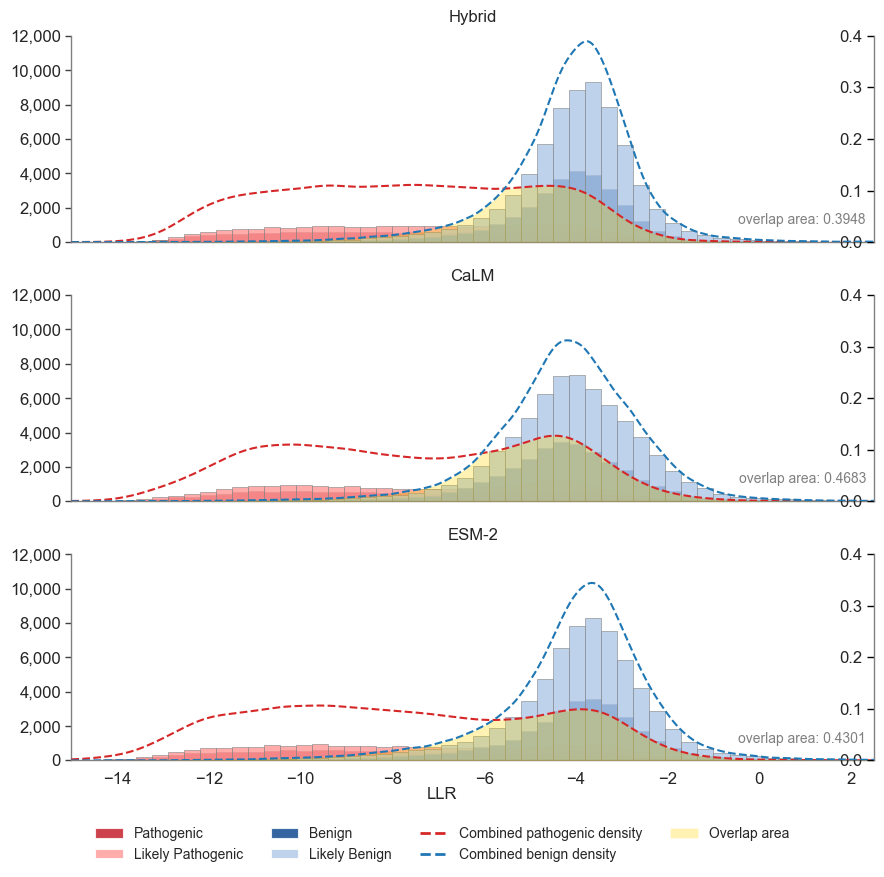

In [11]:
plot_histogram_and_density(**plot_data)

Hybrid vs CaLM: P-value = 1.09e-06
Hybrid vs ESM-2: P-value = 1.12e-04


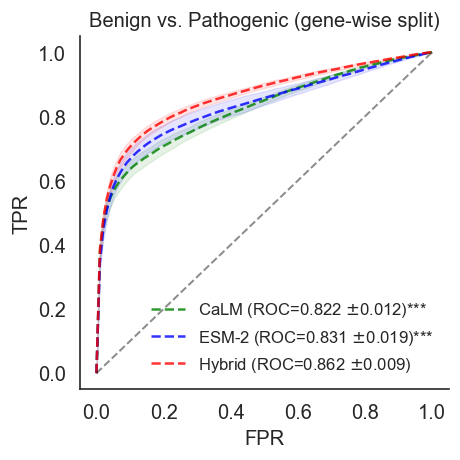

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
import scipy.stats as st

def get_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

aucs_base = results['Hybrid']['rocs']

p_values = {}

for name in ['CaLM', 'ESM-2']:
    aucs_curr = results[name]['rocs']

    stat, p_val = st.ttest_rel(aucs_base, aucs_curr)

    p_values[name] = p_val
    print(f"Hybrid vs {name}: P-value = {p_val:.2e}")


plt.figure(figsize=(4, 4), dpi=120)
ax = plt.gca()

colors = {'Hybrid': 'red', 'ESM-2': 'blue', 'CaLM': 'green'}
styles = {'Hybrid': '--', 'ESM-2': '--', 'CaLM': '--'}


for name in ['CaLM', 'ESM-2', 'Hybrid']:

    mean_tpr = np.mean(results[name]['tprs'], axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)

    std_auc = np.std(results[name]['rocs'])

    if name == 'Hybrid':

        label_str = f"{name} (ROC={mean_auc:.3f} $\pm${std_auc:.3f})"
        linestyle = '--'
        linewidth = 1.5
    else:

        p = p_values[name]
        stars = get_stars(p)
        label_str = f"{name} (ROC={mean_auc:.3f} $\pm${std_auc:.3f}){stars}"
        linestyle = styles[name]
        linewidth = 1.5

    plt.plot(mean_fpr, mean_tpr, color=colors[name], ls=linestyle, lw=linewidth, alpha=0.8,
             label=label_str)

    std_tpr = np.std(results[name]['tprs'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[name], alpha=0.1)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.title('Benign vs. Pathogenic (gene-wise split)', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc="lower right", frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

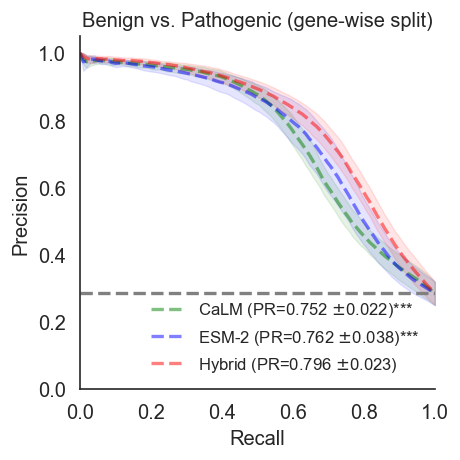

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']


ap_base = results['Hybrid']['prs']

plt.figure(figsize=(4, 4), dpi=120)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
ax = plt.gca()

colors = {'Hybrid': 'red', 'ESM-2': 'blue', 'CaLM': 'green'}
labels = {'Hybrid': 'Hybrid', 'CaLM': 'CaLM', 'ESM-2': 'ESM-2'}


for model in ['CaLM', 'ESM-2', 'Hybrid']:

    precisions_matrix = np.array(results[model]['precisions'])

    mean_precision = np.mean(precisions_matrix, axis=0)
    std_precision = np.std(precisions_matrix, axis=0)

    mean_ap = np.mean(results[model]['prs'])
    std_ap = np.std(results[model]['prs'])


    if model == 'Hybrid':

        label_str = f"{labels[model]} (PR={mean_ap:.3f} $\pm${std_ap:.3f})"
    else:

        ap_curr = results[model]['prs']
        stat, p_val = st.ttest_rel(ap_curr, ap_base)


        stars = get_stars(p_val)
        label_str = f"{labels[model]} (PR={mean_ap:.3f} $\pm${std_ap:.3f}){stars}"

    plt.plot(mean_recall, mean_precision, ls='--',
             label=label_str,
             color=colors[model], lw=2, alpha=0.5)

    plt.fill_between(mean_recall,
                     np.maximum(mean_precision - std_precision, 0),
                     np.minimum(mean_precision + std_precision, 1),
                     color=colors[model], alpha=0.1)


baseline = np.sum(y_true == 1) / len(y_true)
plt.plot([0, 1], [baseline, baseline], linestyle='--', lw=2, color='gray')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Benign vs. Pathogenic (gene-wise split)', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc="lower right", frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

## 6. Training

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

colors = {
'line': '#3C5488',
'shade': '#3C5488',
'sample': '#E64B35',
'best': '#DC0000',
'rug': '#00A087',
'gray': '#7E6148'
}

def style_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=5)

def plot_each_fold(results):

    fig, axes = plt.subplots(5, 2, figsize=(6, 8), dpi=150,
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for i, bo_data in enumerate(results['BO_History']):
        ax = axes[i]
        style_ax(ax)

        ax.set_ylim(0.8, 0.9)

        ax.plot(bo_data['w_grid'], bo_data['roc_landscape'],
                color='gray', alpha=0.6, lw=1, linestyle='-', zorder=1,
                label='Optimization Landscape' if i == 0 else "")

        ax.scatter(bo_data['sampled_w'], bo_data['sampled_roc'],
                   color=colors['sample'], s=25, alpha=0.6, linewidth=0.5, zorder=2,
                   label='BO Samples' if i == 0 else "")

        ax.scatter(bo_data['best_w'], bo_data['best_roc'],
                   color=colors['best'], marker='*', s=50, zorder=10, linewidth=1,
                   label='Best weight' if i == 0 else "")

        ax.text(0.95, 0.05, f"w={bo_data['best_w']:.2f}",
                transform=ax.transAxes, fontsize=8,
                ha='right', va='bottom', color='#333333')

        ax.set_title(f"Fold {i+1}", fontsize=10, pad=5, loc='center')


    fig.supxlabel(r'Weight for CaLM', fontsize=10, y=0.1)
    fig.supylabel('ROC (Training)', fontsize=10, x=0.02)


    handles, labels = axes[0].get_legend_handles_labels()

    plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.3, wspace=0.1)


    plt.show()

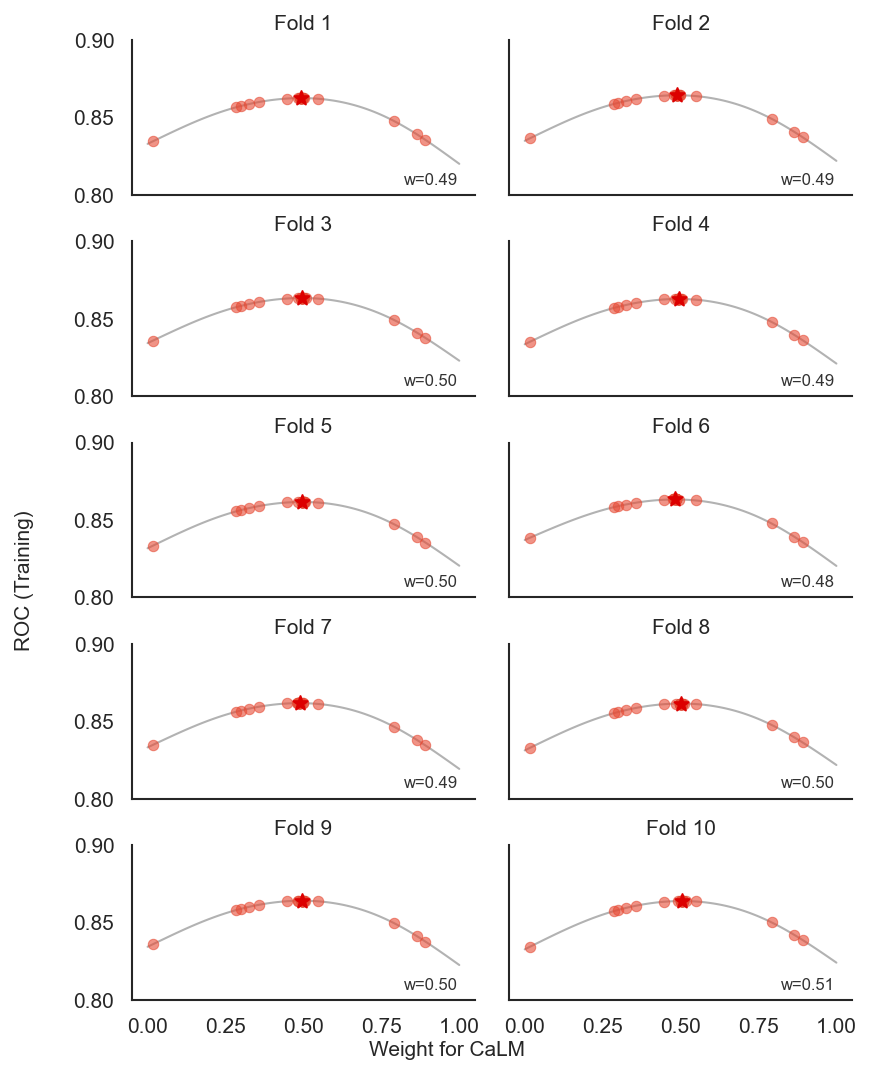

In [15]:
plot_each_fold(results)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

def style_ax(ax):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=5, colors='black')


def plot_mean_fold(results):

    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    style_ax(ax)

    w_grid = results['BO_History'][0]['w_grid']
    landscape_matrix = np.array([fold['roc_landscape'] for fold in results['BO_History']])
    best_ws = [fold['best_w'] for fold in results['BO_History']]

    mean_auc = np.mean(landscape_matrix, axis=0)
    std_auc = np.std(landscape_matrix, axis=0)
    mean_best_w = np.mean(best_ws)

    ax.plot(w_grid, mean_auc, color='red', lw=2, alpha = 0.5, linestyle='--', label='Mean ROC')

    ax.fill_between(w_grid, mean_auc - std_auc, mean_auc + std_auc,
                    color=colors['shade'], alpha=0.15, edgecolor='none',
                    label='±1 Std Dev')

    ax.axvline(mean_best_w, color='gray', linestyle='--', alpha=0.5, lw=1.5, zorder=5)

    text_x = mean_best_w + 0.03
    text_y = 0.885
    ha_align = 'left'

    if mean_best_w > 0.75:
        text_x = mean_best_w - 0.03
        ha_align = 'right'

    ax.text(text_x, text_y,
            f'w={mean_best_w:.2f}',
            color='gray',
            fontsize=10,
            fontweight='bold',
            ha=ha_align,
            va='center',
            )

    ax.set_ylim(0.8, 0.9)
    ax.set_xlim(0, 1)

    ax.set_xlabel(r'Weight for CaLM', fontsize=12)
    ax.set_ylabel('ROC (Training)', fontsize=12)

    plt.tight_layout()
    plt.show()

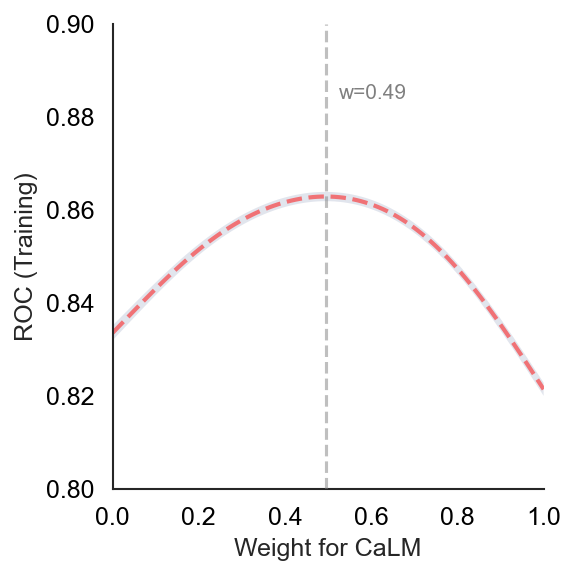

In [17]:
plot_mean_fold(results)